In [37]:
import json
from utils.gho_filter import filter_gho_users

with open('results.json', 'r') as fp:
    res = json.load(fp)
data = []
for entry in res:
    data += entry['data']['users']

gho_users = set(filter_gho_users(data))

In [38]:
with open('results_v2.json', 'r') as fp:
    res = json.load(fp)
v2_data = []
for entry in res:
    v2_data += entry['data']['users']

In [7]:
v2_users = set([entry['id'] for entry in v2_data])

In [34]:
tokens_of_interest = ["USDC", "USDT", "WETH", "DAI", "WBTC", "GHO", "LUSD", "PYUSD", "crvUSD"]

In [39]:
new_borrows = []
history = 'borrowHistory'
for entry in data:
    user_ordered_tx = sorted([c for c in entry[history]], key=lambda x: x['timestamp'])
    if len(user_ordered_tx) == 0:
        continue
    if entry['id'] in v2_users:
        continue
    elif user_ordered_tx[0]['timestamp'] > 1720965600:
        continue
    elif user_ordered_tx[0]['reserve']['symbol'] not in tokens_of_interest:
        continue
    else:
        new_borrows.append(entry)
len(new_borrows)

13943

In [40]:
user_actions = {}
for entry in new_borrows:
    actions = entry['borrowHistory'] + entry['supplyHistory']
    user_ordered_tx = sorted(actions, key=lambda x: x['timestamp'])
    # we remove the supply txs prior to any first borrow
    first_reached = False
    filtered_actions = []
    for a in user_ordered_tx:
        if (first_reached == False) and a['action'] != 'Borrow':
            continue
        else:
            first_reached = True
            filtered_actions.append(a)
    user_actions[entry['id']] = filtered_actions

In [41]:
user_actions['0x00001e52eae2f7305b198b9e4f2c64fb1102de11']

[{'action': 'Borrow',
  'amount': '10000000000',
  'assetPriceUSD': '1.00021167',
  'borrowRate': '31396382654758986483078096',
  'borrowRateMode': 2,
  'caller': {'id': '0x00001e52eae2f7305b198b9e4f2c64fb1102de11'},
  'referrer': None,
  'reserve': {'debtCeiling': None,
   'decimals': 6,
   'name': 'USD Coin',
   'symbol': 'USDC'},
  'stableTokenDebt': '0',
  'timestamp': 1687267319,
  'txHash': '0x1d1b18a383940addff833397f3a8e176463e5d931e7d34826ef341bb18c56232',
  'variableTokenDebt': '9878316377'}]

In [42]:
def categorize_actions(num_actions):
    return min(num_actions, 7)

In [43]:
token_survival_rates = {}

In [44]:
from collections import defaultdict
import matplotlib.pyplot as plt

def compute_survival_rates(user_actions):
    token_survival = defaultdict(lambda: [0] * 10)
    token_users = defaultdict(int)

    for user, actions in user_actions.items():
        if not actions:
            continue
        
        first_token = actions[0]['reserve']['symbol']
        token_users[first_token] += 1
        
        for i in range(min(len(actions), 10)):
            token_survival[first_token][min(i, 9)] += 1

    survival_rates = {}
    for token, counts in token_survival.items():
        total_users = token_users[token]
        rates = [count / total_users for count in counts]
        survival_rates[token] = rates

    return survival_rates

survival_rates = compute_survival_rates(user_actions)

In [45]:
survival_rates

{'USDC': [1.0,
  0.7564457702961858,
  0.6369060302578308,
  0.5329213722565523,
  0.450884295759642,
  0.38866396761133604,
  0.34327722139356487,
  0.30428297464308546,
  0.27551672704027275,
  0.25335606222032814],
 'USDT': [1.0,
  0.7537757437070938,
  0.6299771167048055,
  0.5283752860411899,
  0.45423340961098396,
  0.39748283752860414,
  0.34210526315789475,
  0.30045766590389017,
  0.26704805491990846,
  0.2411899313501144],
 'DAI': [1.0,
  0.7668393782383419,
  0.6404145077720207,
  0.522279792746114,
  0.4466321243523316,
  0.39481865284974094,
  0.35233160621761656,
  0.32020725388601035,
  0.2911917098445596,
  0.26528497409326424],
 'crvUSD': [1.0,
  0.8205128205128205,
  0.5384615384615384,
  0.4358974358974359,
  0.41025641025641024,
  0.3076923076923077,
  0.28205128205128205,
  0.20512820512820512,
  0.1282051282051282,
  0.1282051282051282],
 'GHO': [1.0,
  0.6188118811881188,
  0.504950495049505,
  0.41707920792079206,
  0.36386138613861385,
  0.29826732673267325,
  

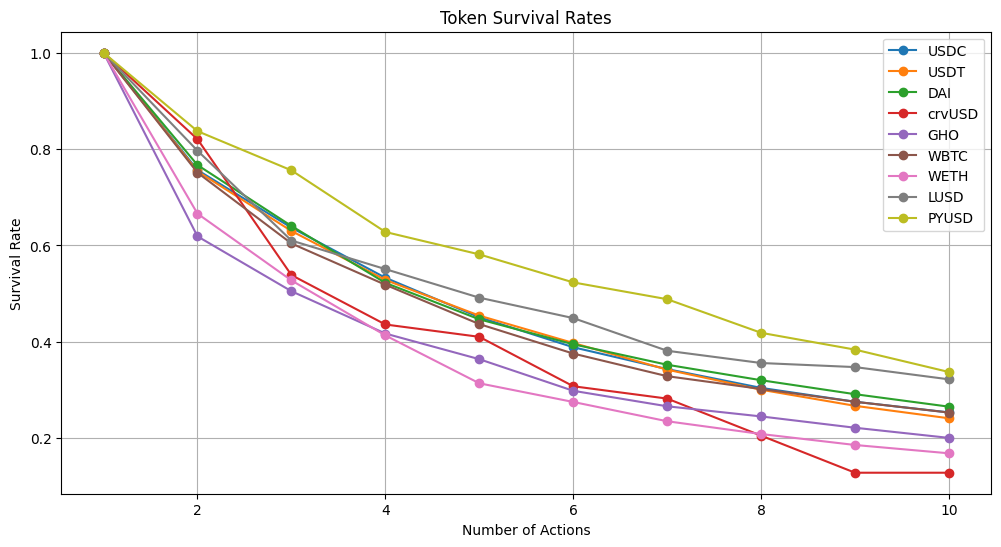

In [46]:
plt.figure(figsize=(12, 6))
for token, rates in survival_rates.items():
    plt.plot(range(1, 11), rates, marker='o', label=token)

plt.xlabel('Number of Actions')
plt.ylabel('Survival Rate')
plt.title('Token Survival Rates')
plt.legend()
plt.grid(True)